## CV Assignment 3 - Task 2

Name: Muhammad Fahad Waqar<br>
Student No: st125981

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import random
import time

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Synthetic Dataset Creation
def generate_synthetic_data(num_images, img_size, num_classes):
    images = []
    masks = []
    
    for _ in range(num_images):
        img = np.zeros((img_size, img_size, 3), dtype=np.float32)
        mask = np.zeros((img_size, img_size), dtype=np.int64)
        
        # Class 0 is background
        
        # Add a shape for class 1 (e.g., a square)
        c1_x1, c1_y1 = random.randint(0, img_size - 10), random.randint(0, img_size - 10)
        c1_x2, c1_y2 = random.randint(c1_x1 + 5, img_size), random.randint(c1_y1 + 5, img_size)
        img[c1_y1:c1_y2, c1_x1:c1_x2, 0] = random.uniform(0.5, 1.0) # Red channel
        mask[c1_y1:c1_y2, c1_x1:c1_x2] = 1
        
        if num_classes > 2:
            # Add a shape for class 2
            c2_center_x, c2_center_y = random.randint(0, img_size - 1), random.randint(0, img_size - 1)
            c2_radius = random.randint(5, img_size // 4)
            Y, X = np.ogrid[:img_size, :img_size]
            dist_from_center = np.sqrt((X - c2_center_x)**2 + (Y - c2_center_y)**2)
            
            circle_mask = dist_from_center <= c2_radius
            img[circle_mask, 1] = random.uniform(0.5, 1.0) # Green channel
            mask[circle_mask] = 2 # Class 2
        
        images.append(img)
        masks.append(mask)
        
    return images, masks

class SyntheticDataset(Dataset):
    def __init__(self, images, masks, transforms=None):
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transforms:
            image = self.transforms(image)
            
        # Convert mask to tensor
        mask = torch.from_numpy(mask).long()
        
        return image, mask

# Configuration
IMG_SIZE = 224
NUM_CLASSES = 3
NUM_TRAIN = 50
NUM_TEST = 10
BATCH_SIZE = 4
EPOCHS = 20

In [9]:
import torchvision.models as models
import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self, num_classes, variant='fcn8s', upsample_mode='transpose'):
        super(FCN, self).__init__()
        
        self.num_classes = num_classes
        self.variant = variant
        self.upsample_mode = upsample_mode
        
        # Load pre-trained ResNet-50 backbone
        # We use weights=... for the modern API
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Extract layers from backbone (remove avgpool and fc)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1 # stride 4
        # The "pool" layers in FCN paper correspond to ResNet layer outputs
        self.layer2 = resnet.layer2 # pool3 (stride 8)
        self.layer3 = resnet.layer3 # pool4 (stride 16)
        self.layer4 = resnet.layer4 # pool5 (stride 32)

        # 1x1 convolutions to reduce channel depth to num_classes
        # These are the "score" layers
        self.score_pool3 = nn.Conv2d(512, num_classes, 1)  # from layer2
        self.score_pool4 = nn.Conv2d(1024, num_classes, 1) # from layer3
        self.score_pool5 = nn.Conv2d(2048, num_classes, 1) # from layer4

        # Define upsampling layers based on mode
        if self.upsample_mode == 'transpose':
            # We need distinct upsamplers for the different skip-connection stages
            self.upsample2x_1 = nn.ConvTranspose2d(num_classes, num_classes, 4, stride=2, padding=1)
            self.upsample2x_2 = nn.ConvTranspose2d(num_classes, num_classes, 4, stride=2, padding=1)
            self.upsample8x = nn.ConvTranspose2d(num_classes, num_classes, 16, stride=8, padding=4)
            self.upsample16x = nn.ConvTranspose2d(num_classes, num_classes, 32, stride=16, padding=8)
            self.upsample32x = nn.ConvTranspose2d(num_classes, num_classes, 64, stride=32, padding=16)
        else: # 'bilinear'
            # Bilinear upsampling is done in the forward pass with F.interpolate
            # No layers needed here
            pass
            
    def _upsample(self, x, scale_factor):
        """Helper for bilinear upsampling"""
        return F.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Get original size for final interpolation
        original_size = x.shape[2:]

        # Backbone feature extraction
        c1 = self.layer0(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2) # pool3 (stride 8)
        c4 = self.layer3(c3) # pool4 (stride 16)
        c5 = self.layer4(c4) # pool5 (stride 32)
        
        # Apply 1x1 convolutions to get class scores
        s3 = self.score_pool3(c3)
        s4 = self.score_pool4(c4)
        s5 = self.score_pool5(c5)

        # Upsampling and skip connections based on variant
        if self.variant == 'fcn32s':
            # FCN-32s: Upsample from pool5 (s5) 32x in one go
            if self.upsample_mode == 'transpose':
                out = self.upsample32x(s5)
            else:
                out = self._upsample(s5, scale_factor=32)
        
        elif self.variant == 'fcn16s':
            # FCN-16s: Upsample pool5 (s5) 2x and add to pool4 (s4)
            if self.upsample_mode == 'transpose':
                x_s5_up = self.upsample2x_1(s5)
            else:
                x_s5_up = self._upsample(s5, scale_factor=2)
            
            x_s4_add = x_s5_up + s4
            
            # Upsample combined 16x
            if self.upsample_mode == 'transpose':
                out = self.upsample16x(x_s4_add)
            else:
                out = self._upsample(x_s4_add, scale_factor=16)
        
        elif self.variant == 'fcn8s':
            # FCN-8s: Upsample pool5 (s5) 2x and add to pool4 (s4)
            if self.upsample_mode == 'transpose':
                x_s5_up = self.upsample2x_1(s5)
            else:
                x_s5_up = self._upsample(s5, scale_factor=2)
            
            x_s4_add = x_s5_up + s4
            
            # Upsample combined 2x and add to pool3 (s3)
            if self.upsample_mode == 'transpose':
                x_s4_up = self.upsample2x_2(x_s4_add)
            else:
                x_s4_up = self._upsample(x_s4_add, scale_factor=2)
                
            x_s3_add = x_s4_up + s3
            
            # Upsample combined 8x
            if self.upsample_mode == 'transpose':
                out = self.upsample8x(x_s3_add)
            else:
                out = self._upsample(x_s3_add, scale_factor=8)
        
        else:
            raise ValueError(f"Unknown variant: {self.variant}")

        # Final interpolation to match original input size
        # This handles any off-by-one pixel issues
        out = F.interpolate(out, size=original_size, mode='bilinear', align_corners=False)
        
        return out

In [10]:
from sklearn.metrics import jaccard_score
import time

# Metric Calculation
def calculate_metrics(preds, targets, num_classes):
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    
    # Pixel Accuracy
    correct = np.sum(preds == targets)
    total = targets.size
    pixel_acc = correct / total
    
    # Mean IoU
    preds_flat = preds.ravel()
    targets_flat = targets.ravel()
    
    mean_iou = jaccard_score(targets_flat, preds_flat, 
                             labels=list(range(num_classes)), 
                             average='macro',
                             zero_division=0) # Handle classes not in batch
    
    return pixel_acc, mean_iou

# Training Functions
def train_model(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_pix_acc = 0
    epoch_miou = 0
    
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1)
        pix_acc, miou = calculate_metrics(preds, masks, model.num_classes)
        epoch_pix_acc += pix_acc
        epoch_miou += miou
        
    num_batches = len(loader)
    return (epoch_loss / num_batches, 
            epoch_pix_acc / num_batches, 
            epoch_miou / num_batches)

def evaluate_model(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_pix_acc = 0
    epoch_miou = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            pix_acc, miou = calculate_metrics(preds, masks, model.num_classes)
            epoch_pix_acc += pix_acc
            epoch_miou += miou
            
    num_batches = len(loader)
    return (epoch_loss / num_batches, 
            epoch_pix_acc / num_batches, 
            epoch_miou / num_batches)


# Plotting and Visualization Helpers
NUM_CLASSES = 3 # 0:bg, 1:class_A, 2:class_B
COLOR_MAP = np.array([
    [0, 0, 0],    # 0 - background (black)
    [255, 0, 0],  # 1 - class A (red)
    [0, 255, 0],  # 2 - class B (green)
    # Add more colors if you have more classes
]) / 255.0

# Denormalization transform
INV_NORMALIZE = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def denormalize(tensor):
    return INV_NORMALIZE(tensor)

def get_color_mask(mask_tensor):
    mask_np = mask_tensor.cpu().numpy().astype(int)
    # Ensure mask values are within the color map range
    mask_np = np.clip(mask_np, 0, len(COLOR_MAP) - 1)
    color_mask = COLOR_MAP[mask_np]
    return torch.from_numpy(color_mask).permute(2, 0, 1) # (3, H, W)

def plot_training_curves(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=16)
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(history['train_miou'], label='Train Mean IoU')
    ax2.plot(history['val_miou'], label='Val Mean IoU')
    ax2.plot(history['train_acc'], label='Train Pixel Acc')
    ax2.plot(history['val_acc'], label='Val Pixel Acc')
    ax2.set_title(f'Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy / mIoU')
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def visualize_results(model, loader, title, num_to_show=3):
    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    
    num_to_show = min(num_to_show, len(images))
    fig, axes = plt.subplots(num_to_show, 3, figsize=(12, num_to_show * 4))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_to_show):
        img = denormalize(images[i]).cpu().permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)
        
        gt_mask = get_color_mask(masks[i]).permute(1, 2, 0)
        pred_mask = get_color_mask(preds[i]).permute(1, 2, 0)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(gt_mask)
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask)
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Generating synthetic data...
Data loaded.
Image shape: torch.Size([3, 224, 224]), Mask shape: torch.Size([224, 224])


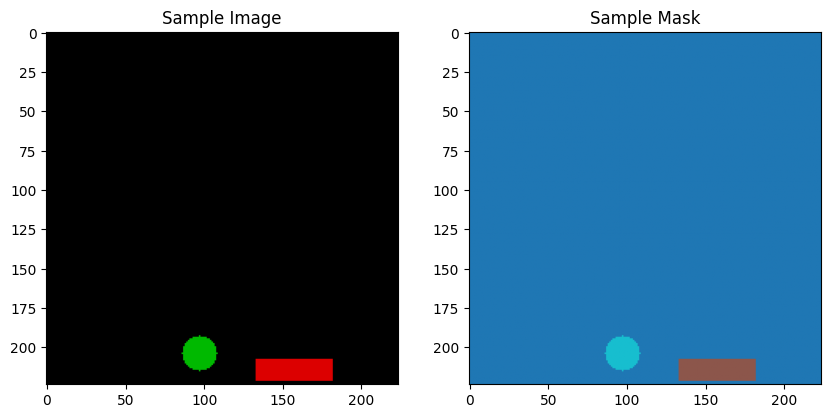


Running Experiment: fcn32s_transpose
Epoch 1/20 - Val mIoU: 0.2526
Epoch 2/20 - Val mIoU: 0.2833
Epoch 3/20 - Val mIoU: 0.2840
Epoch 4/20 - Val mIoU: 0.2842
Epoch 5/20 - Val mIoU: 0.2842
Epoch 6/20 - Val mIoU: 0.2842
Epoch 7/20 - Val mIoU: 0.2921
Epoch 8/20 - Val mIoU: 0.3368
Epoch 9/20 - Val mIoU: 0.4050
Epoch 10/20 - Val mIoU: 0.4301
Epoch 11/20 - Val mIoU: 0.4422
Epoch 12/20 - Val mIoU: 0.4427
Epoch 13/20 - Val mIoU: 0.4405
Epoch 14/20 - Val mIoU: 0.4424
Epoch 15/20 - Val mIoU: 0.4457
Epoch 16/20 - Val mIoU: 0.4528
Epoch 17/20 - Val mIoU: 0.4556
Epoch 18/20 - Val mIoU: 0.4611
Epoch 19/20 - Val mIoU: 0.4647
Epoch 20/20 - Val mIoU: 0.4702
Experiment finished in 21.97 seconds


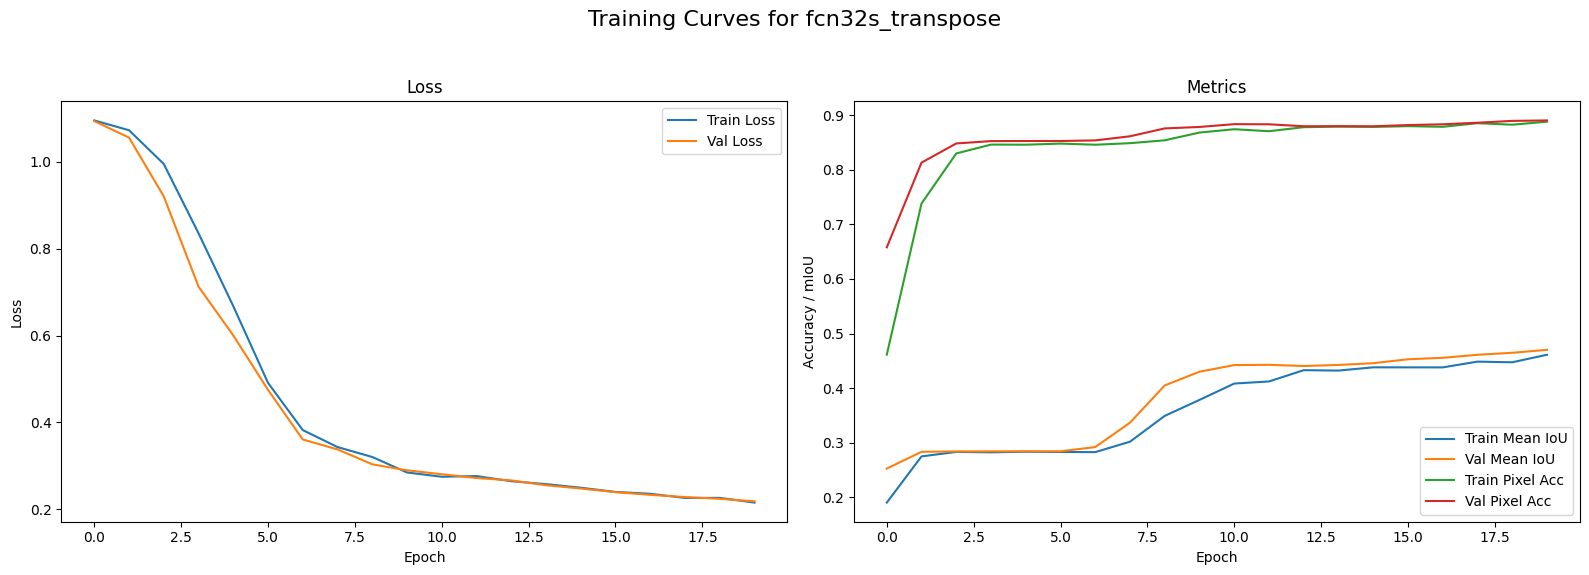

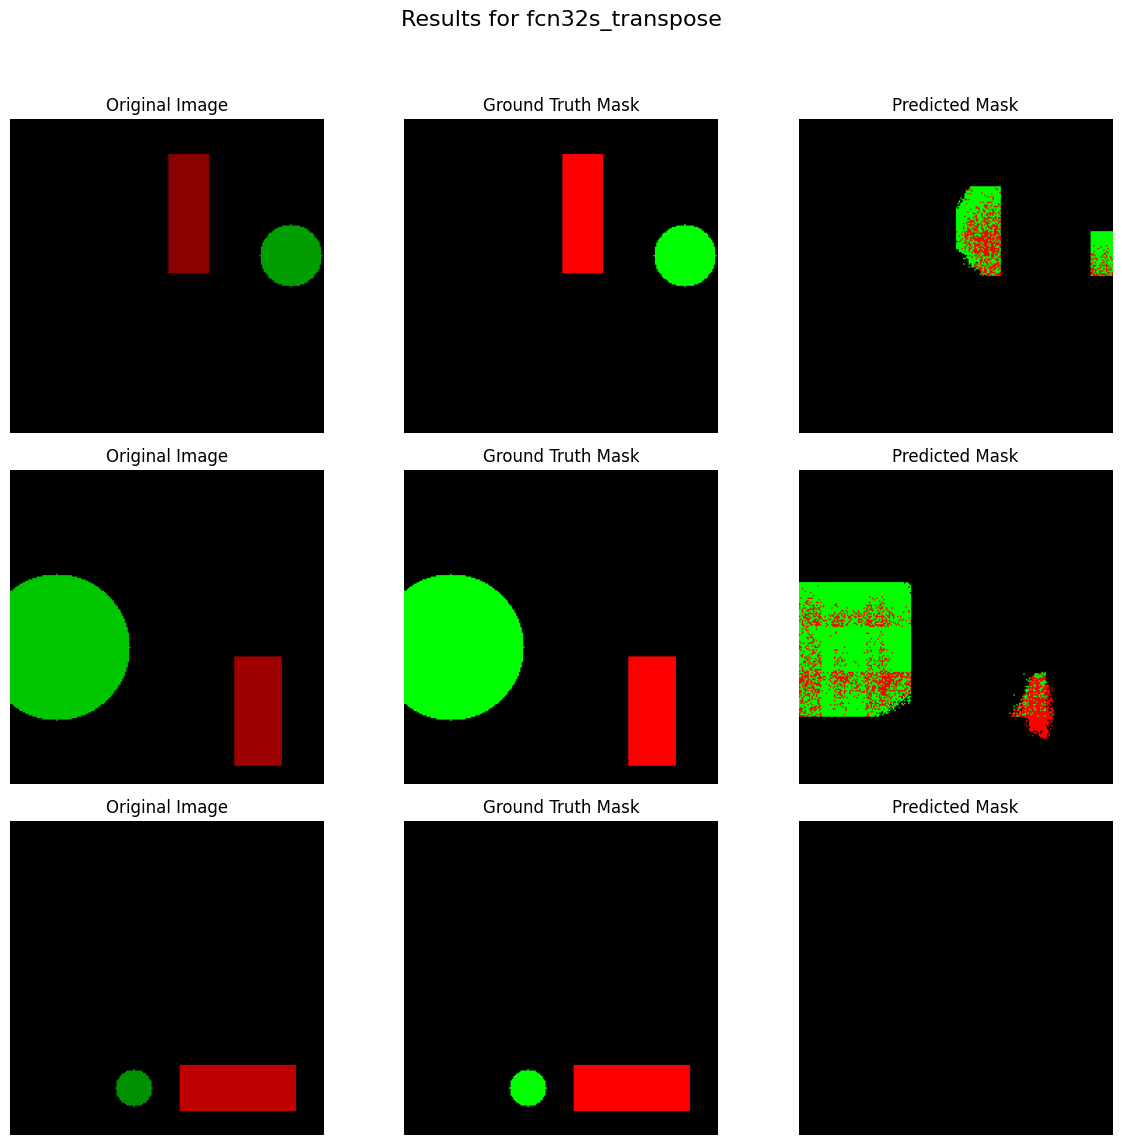


Running Experiment: fcn32s_bilinear
Epoch 1/20 - Val mIoU: 0.2435
Epoch 2/20 - Val mIoU: 0.6001
Epoch 3/20 - Val mIoU: 0.6849
Epoch 4/20 - Val mIoU: 0.7264
Epoch 5/20 - Val mIoU: 0.7418
Epoch 6/20 - Val mIoU: 0.7424
Epoch 7/20 - Val mIoU: 0.7470
Epoch 8/20 - Val mIoU: 0.7486
Epoch 9/20 - Val mIoU: 0.7665
Epoch 10/20 - Val mIoU: 0.7689
Epoch 11/20 - Val mIoU: 0.7664
Epoch 12/20 - Val mIoU: 0.7728
Epoch 13/20 - Val mIoU: 0.7676
Epoch 14/20 - Val mIoU: 0.7673
Epoch 15/20 - Val mIoU: 0.7626
Epoch 16/20 - Val mIoU: 0.7779
Epoch 17/20 - Val mIoU: 0.7719
Epoch 18/20 - Val mIoU: 0.7650
Epoch 19/20 - Val mIoU: 0.7674
Epoch 20/20 - Val mIoU: 0.7716
Experiment finished in 16.07 seconds


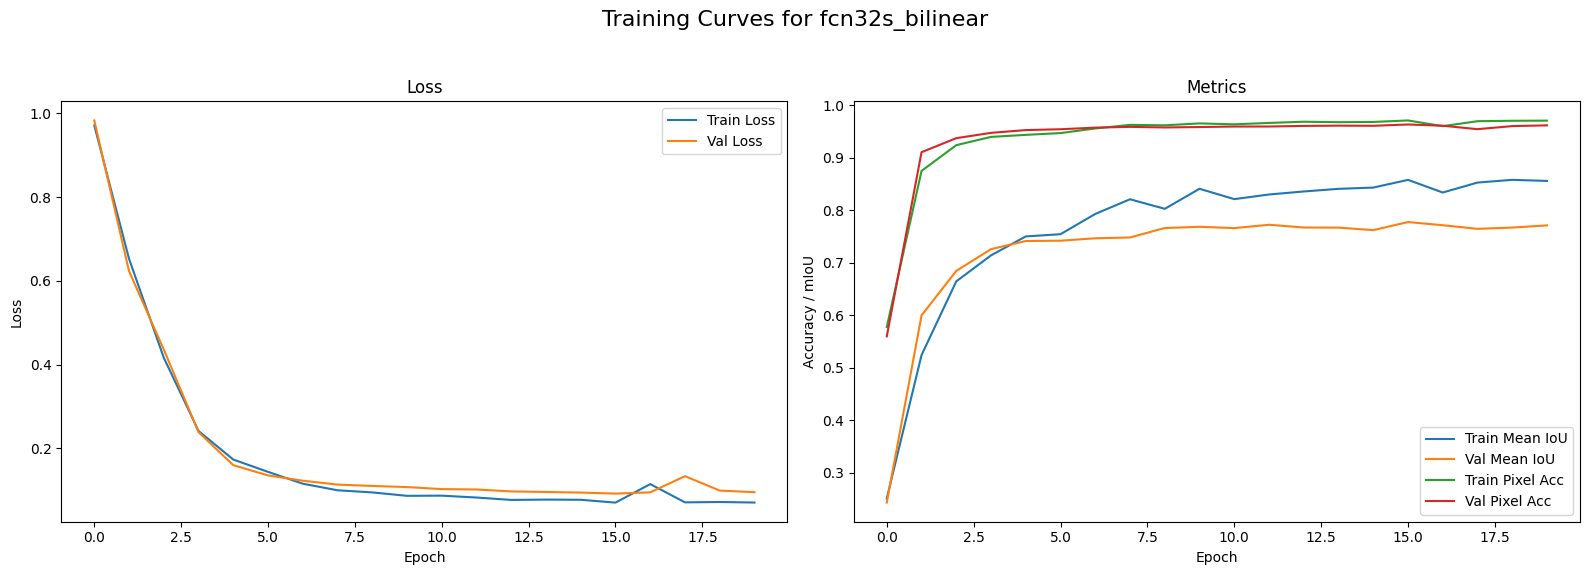

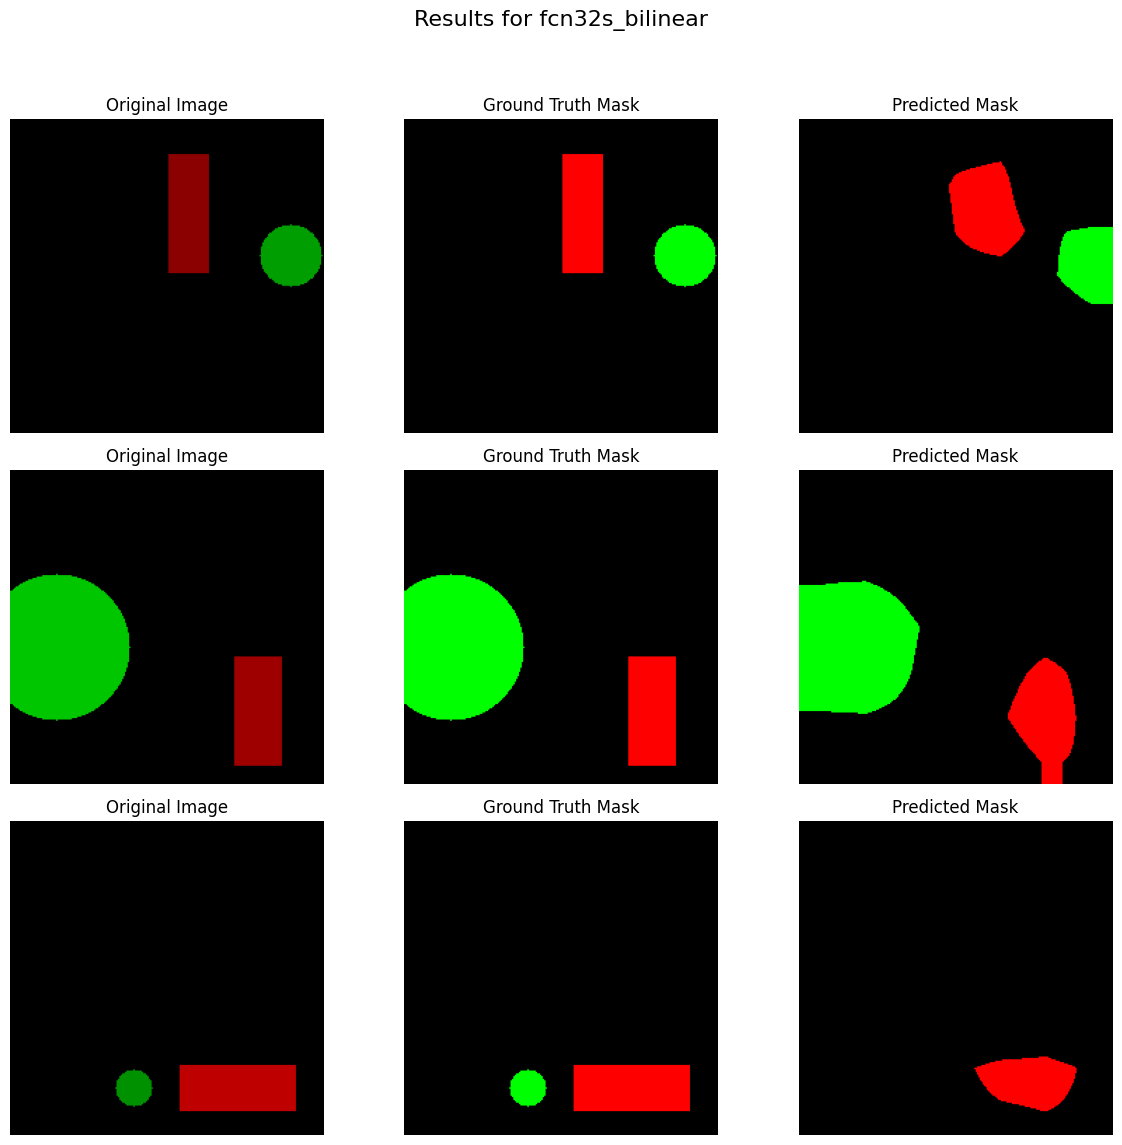


Running Experiment: fcn16s_transpose
Epoch 1/20 - Val mIoU: 0.1721
Epoch 2/20 - Val mIoU: 0.3074
Epoch 3/20 - Val mIoU: 0.4009
Epoch 4/20 - Val mIoU: 0.4355
Epoch 5/20 - Val mIoU: 0.4505
Epoch 6/20 - Val mIoU: 0.4645
Epoch 7/20 - Val mIoU: 0.4787
Epoch 8/20 - Val mIoU: 0.4799
Epoch 9/20 - Val mIoU: 0.4797
Epoch 10/20 - Val mIoU: 0.4845
Epoch 11/20 - Val mIoU: 0.4837
Epoch 12/20 - Val mIoU: 0.4842
Epoch 13/20 - Val mIoU: 0.4865
Epoch 14/20 - Val mIoU: 0.4877
Epoch 15/20 - Val mIoU: 0.4892
Epoch 16/20 - Val mIoU: 0.4953
Epoch 17/20 - Val mIoU: 0.4893
Epoch 18/20 - Val mIoU: 0.4932
Epoch 19/20 - Val mIoU: 0.4834
Epoch 20/20 - Val mIoU: 0.4847
Experiment finished in 16.48 seconds


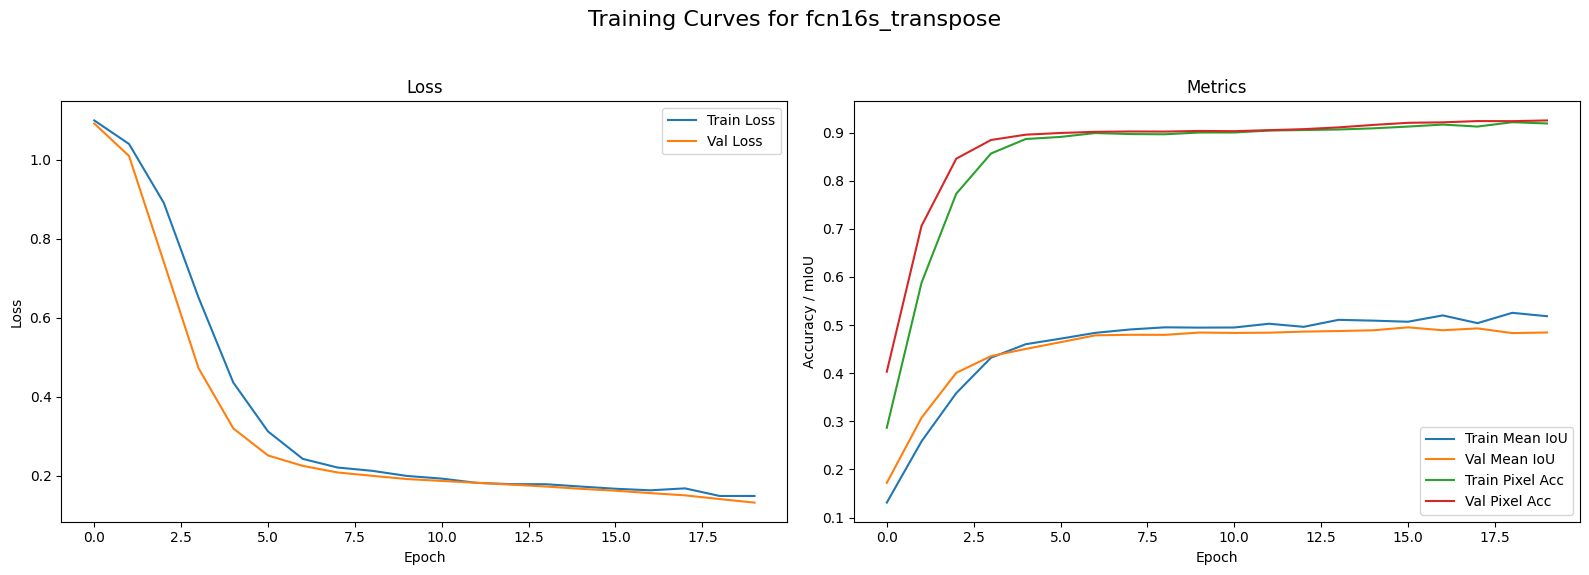

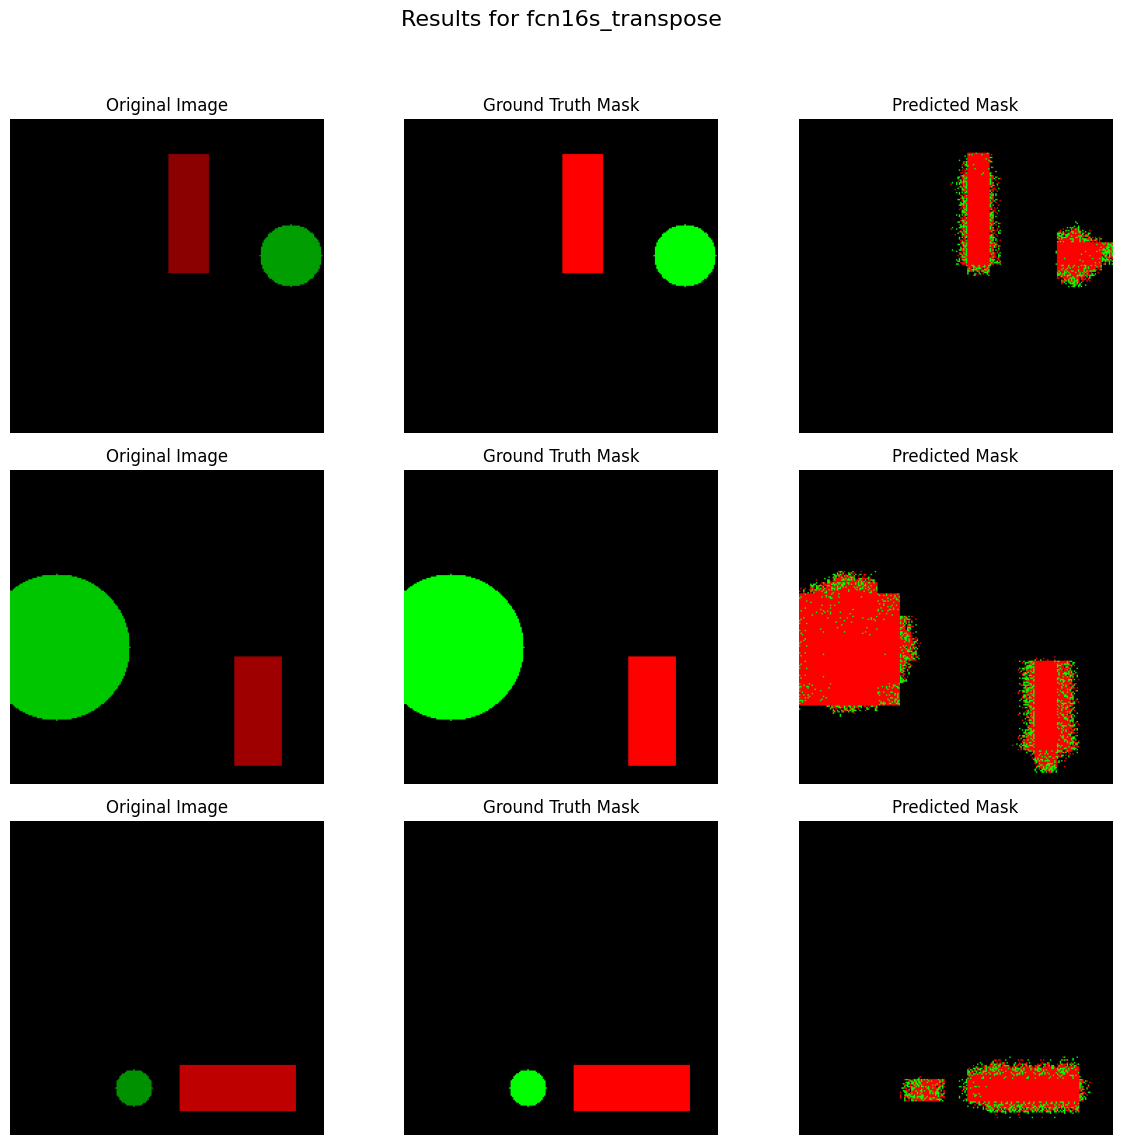


Running Experiment: fcn16s_bilinear
Epoch 1/20 - Val mIoU: 0.5239
Epoch 2/20 - Val mIoU: 0.8010
Epoch 3/20 - Val mIoU: 0.8198
Epoch 4/20 - Val mIoU: 0.8361
Epoch 5/20 - Val mIoU: 0.8363
Epoch 6/20 - Val mIoU: 0.8484
Epoch 7/20 - Val mIoU: 0.8476
Epoch 8/20 - Val mIoU: 0.8604
Epoch 9/20 - Val mIoU: 0.8509
Epoch 10/20 - Val mIoU: 0.8582
Epoch 11/20 - Val mIoU: 0.8684
Epoch 12/20 - Val mIoU: 0.8633
Epoch 13/20 - Val mIoU: 0.8600
Epoch 14/20 - Val mIoU: 0.8619
Epoch 15/20 - Val mIoU: 0.8704
Epoch 16/20 - Val mIoU: 0.8715
Epoch 17/20 - Val mIoU: 0.8687
Epoch 18/20 - Val mIoU: 0.8771
Epoch 19/20 - Val mIoU: 0.8780
Epoch 20/20 - Val mIoU: 0.8776
Experiment finished in 18.24 seconds


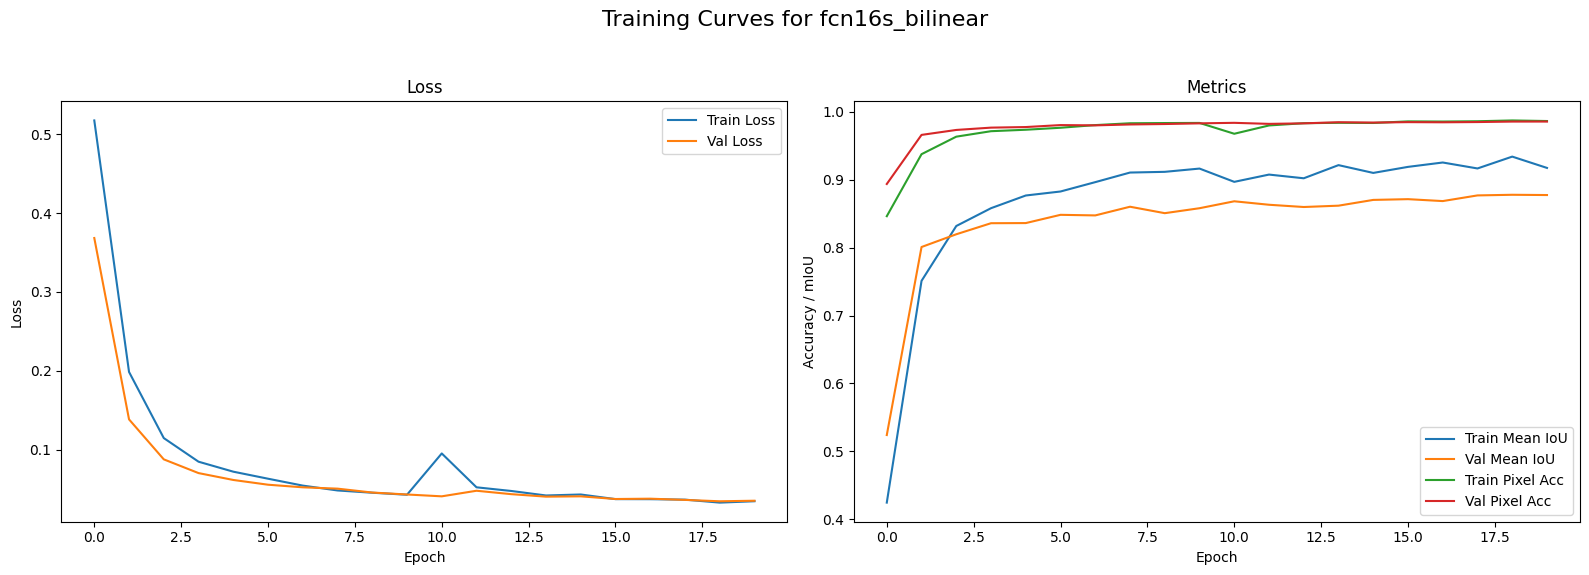

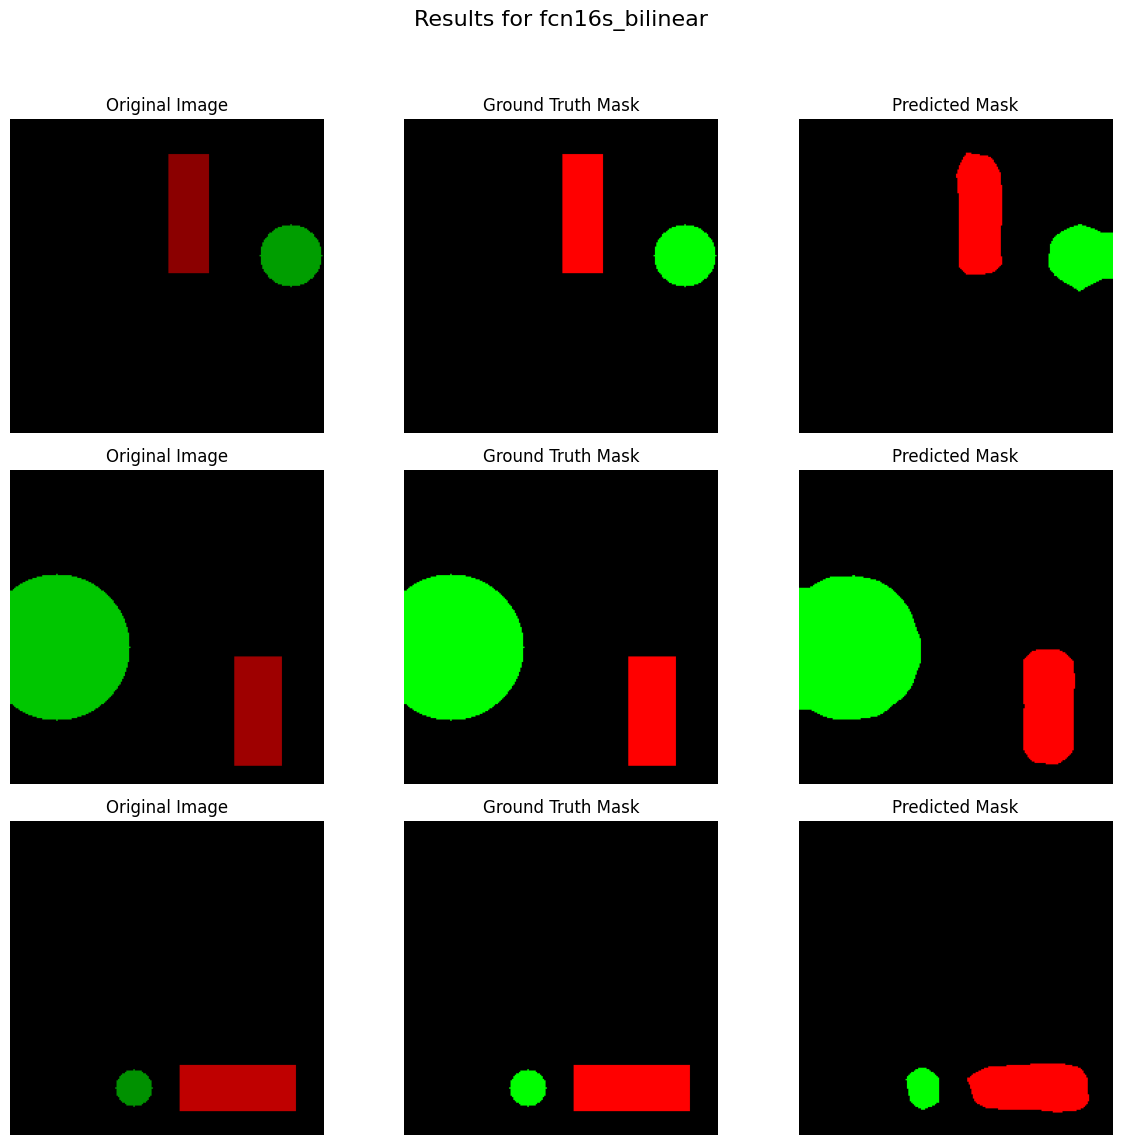


Running Experiment: fcn8s_transpose
Epoch 1/20 - Val mIoU: 0.2286
Epoch 2/20 - Val mIoU: 0.2724
Epoch 3/20 - Val mIoU: 0.3269
Epoch 4/20 - Val mIoU: 0.3845
Epoch 5/20 - Val mIoU: 0.4418
Epoch 6/20 - Val mIoU: 0.4872
Epoch 7/20 - Val mIoU: 0.5097
Epoch 8/20 - Val mIoU: 0.5190
Epoch 9/20 - Val mIoU: 0.5246
Epoch 10/20 - Val mIoU: 0.5342
Epoch 11/20 - Val mIoU: 0.5483
Epoch 12/20 - Val mIoU: 0.5664
Epoch 13/20 - Val mIoU: 0.5820
Epoch 14/20 - Val mIoU: 0.6115
Epoch 15/20 - Val mIoU: 0.6408
Epoch 16/20 - Val mIoU: 0.6781
Epoch 17/20 - Val mIoU: 0.7175
Epoch 18/20 - Val mIoU: 0.7803
Epoch 19/20 - Val mIoU: 0.8189
Epoch 20/20 - Val mIoU: 0.8390
Experiment finished in 16.28 seconds


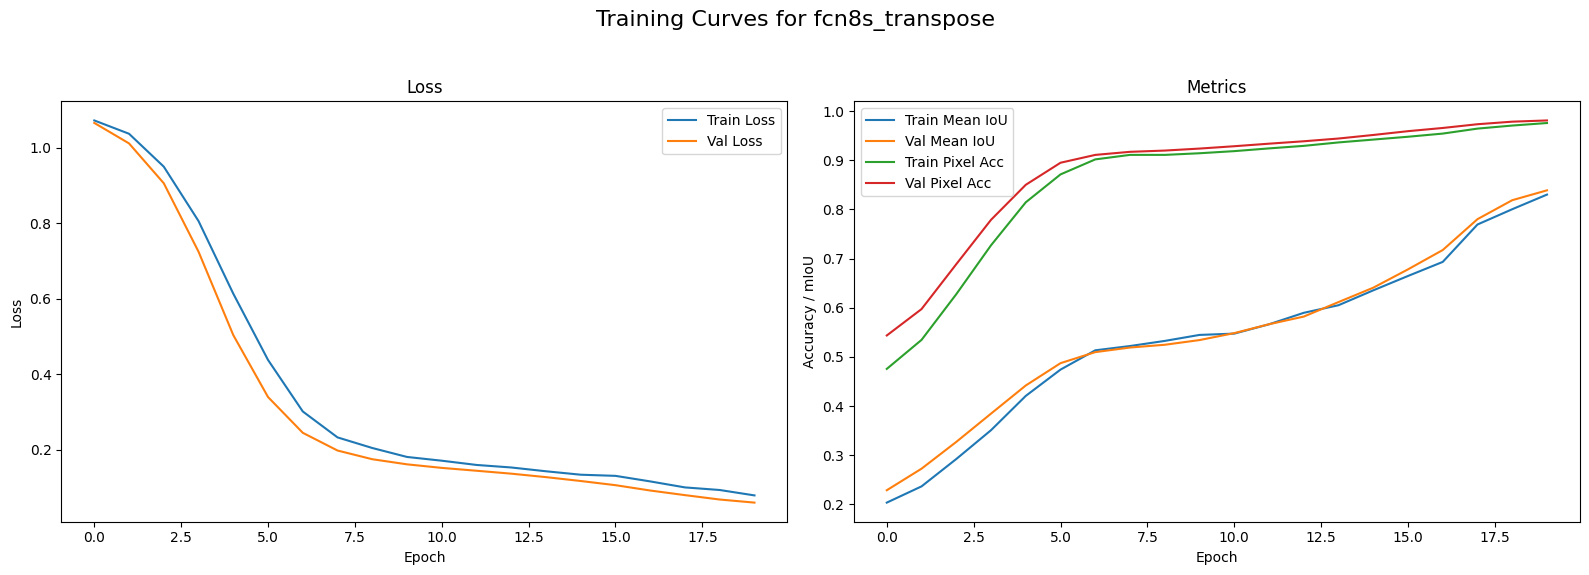

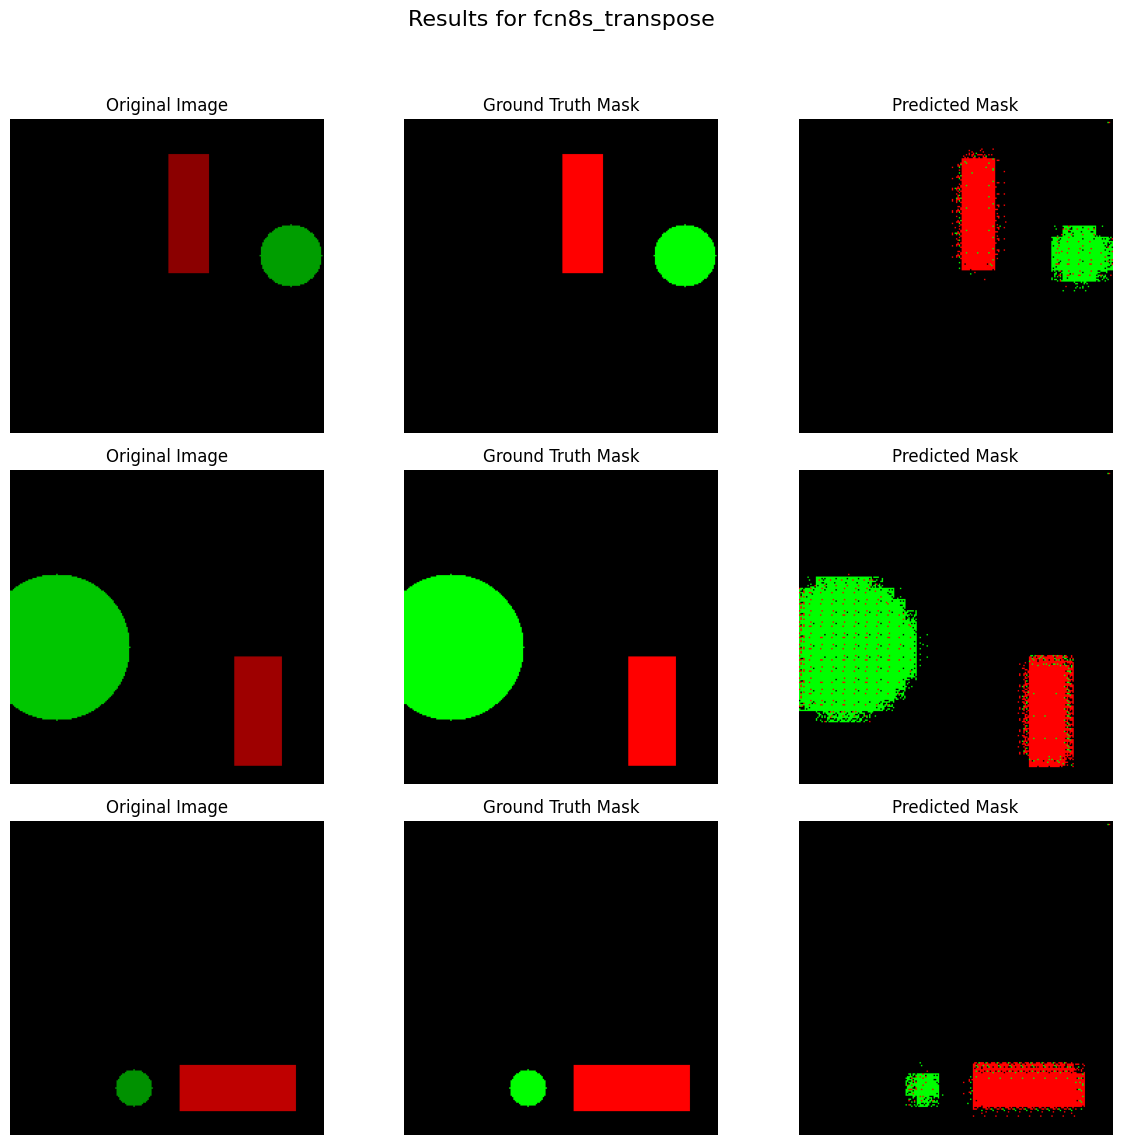


Running Experiment: fcn8s_bilinear
Epoch 1/20 - Val mIoU: 0.6267
Epoch 2/20 - Val mIoU: 0.8023
Epoch 3/20 - Val mIoU: 0.8164
Epoch 4/20 - Val mIoU: 0.8365
Epoch 5/20 - Val mIoU: 0.8526
Epoch 6/20 - Val mIoU: 0.8632
Epoch 7/20 - Val mIoU: 0.8706
Epoch 8/20 - Val mIoU: 0.8750
Epoch 9/20 - Val mIoU: 0.8816
Epoch 10/20 - Val mIoU: 0.8866
Epoch 11/20 - Val mIoU: 0.8834
Epoch 12/20 - Val mIoU: 0.8941
Epoch 13/20 - Val mIoU: 0.9039
Epoch 14/20 - Val mIoU: 0.9090
Epoch 15/20 - Val mIoU: 0.9063
Epoch 16/20 - Val mIoU: 0.9062
Epoch 17/20 - Val mIoU: 0.9143
Epoch 18/20 - Val mIoU: 0.9120
Epoch 19/20 - Val mIoU: 0.9161
Epoch 20/20 - Val mIoU: 0.9191
Experiment finished in 17.20 seconds


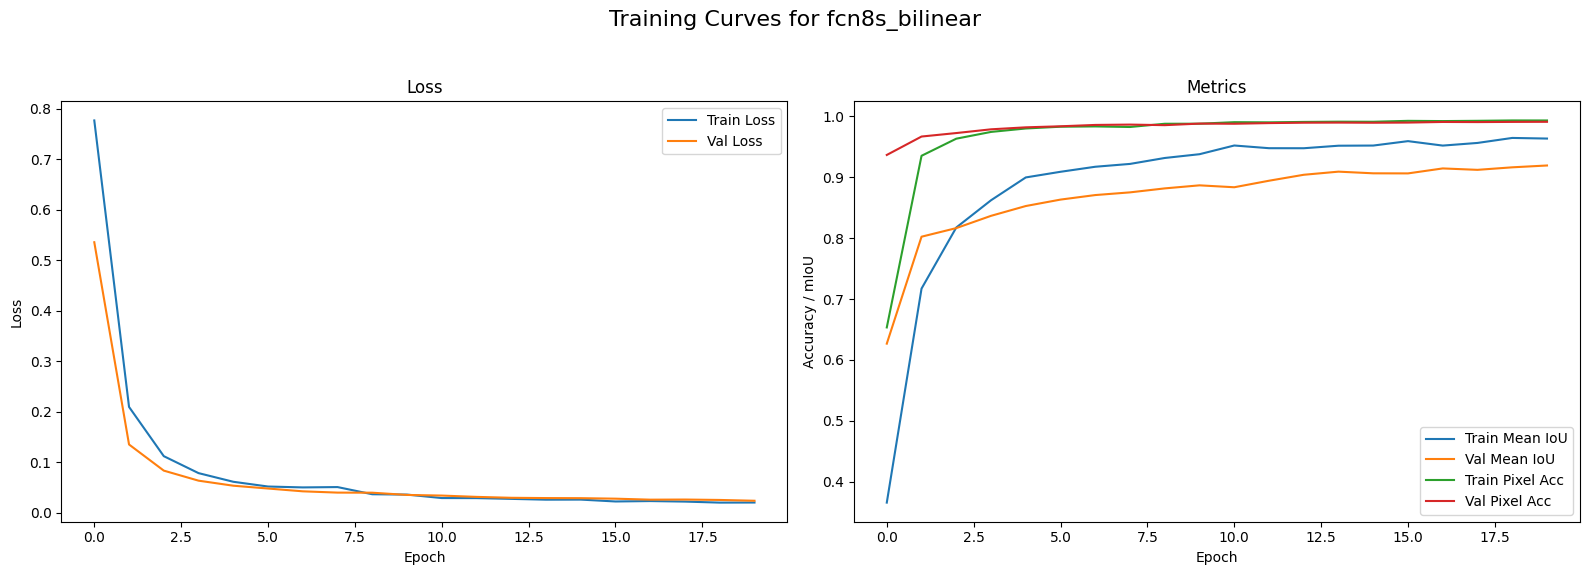

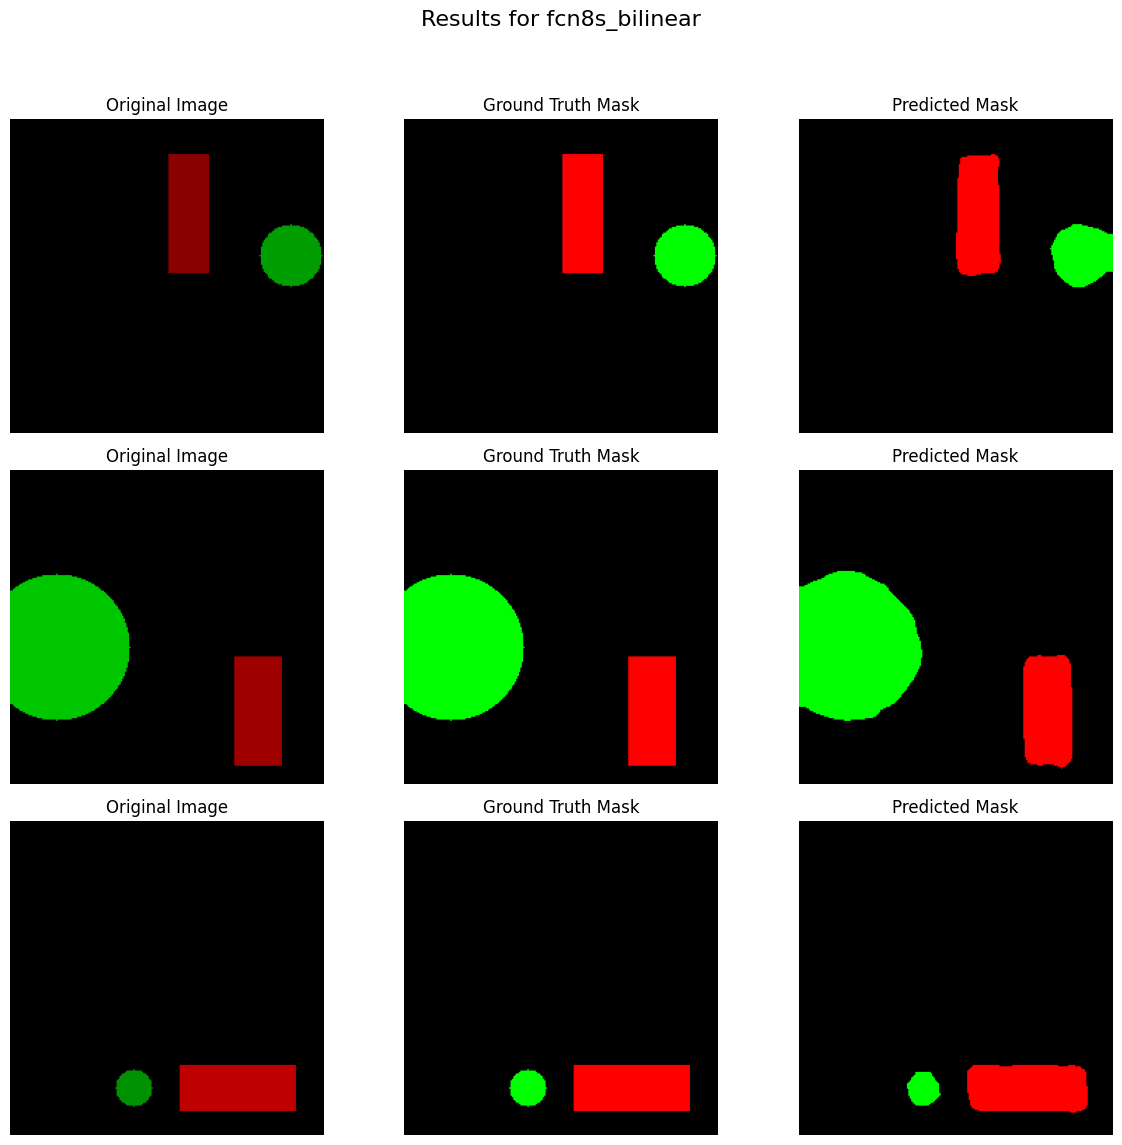


All experiments complete!


In [12]:
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_CLASSES = 3

# Define transforms (normalize for pretrained backbone)
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Generate data
print("Generating synthetic data...")
train_images, train_masks = generate_synthetic_data(NUM_TRAIN, IMG_SIZE, NUM_CLASSES)
test_images, test_masks = generate_synthetic_data(NUM_TEST, IMG_SIZE, NUM_CLASSES)

# Create datasets and dataloaders
train_dataset = SyntheticDataset(train_images, train_masks, transforms=data_transforms)
test_dataset = SyntheticDataset(test_images, test_masks, transforms=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data loaded.")

# Visualize one sample
img, mask = train_dataset[0]
print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Un-normalize image for plotting
img_display = img.permute(1, 2, 0).numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)
plt.imshow(img_display)
plt.title('Sample Image')
plt.subplot(1, 2, 2)
plt.imshow(mask.numpy(), cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
plt.title('Sample Mask')
plt.show()

variants = ['fcn32s', 'fcn16s', 'fcn8s']
upsample_modes = ['transpose', 'bilinear']
all_results = {}

for variant in variants:
    for mode in upsample_modes:
        
        exp_name = f"{variant}_{mode}"
        print(f"\n{'='*30}\nRunning Experiment: {exp_name}\n{'='*30}")
        
        # 1. Initialize Model, Loss, Optimizer
        model = FCN(num_classes=NUM_CLASSES, variant=variant, upsample_mode=mode).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_miou': [], 'val_miou': [],
        }
        
        best_val_miou = -1
        start_time = time.time()

        # 2. Training Loop
        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc, train_miou = train_model(model, train_loader, optimizer, criterion)
            val_loss, val_acc, val_miou = evaluate_model(model, test_loader, criterion)
            
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['train_miou'].append(train_miou)
            history['val_miou'].append(val_miou)
            
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Val mIoU: {val_miou:.4f}")
        
        end_time = time.time()
        print(f"Experiment finished in {end_time - start_time:.2f} seconds")
        
        # 3. Store Final Metrics
        all_results[exp_name] = {
            'variant': variant,
            'mode': mode,
            'final_miou': val_miou,
            'final_acc': val_acc,
            'time': end_time - start_time
        }
        
        # 4. Plot curves and visualize results
        plot_training_curves(history, title=f"Training Curves for {exp_name}")
        visualize_results(model, test_loader, title=f"Results for {exp_name}", num_to_show=3)

print("\nAll experiments complete!")

In [13]:
print("FCN Experiment: Final Comparison Table")

# Print table header
print(f"\n| {'Experiment':<22} | {'Mean IoU':<10} | {'Pixel Acc':<10} | {'Time (s)':<10} |")
print(f"| {'-'*22} | {'-'*10} | {'-'*10} | {'-'*10} |")

# Print table rows
for exp_name, metrics in all_results.items():
    print(f"| {exp_name:<22} | {metrics['final_miou']:<10.4f} | {metrics['final_acc']:<10.4f} | {metrics['time']:<10.2f} |")

FCN Experiment: Final Comparison Table

| Experiment             | Mean IoU   | Pixel Acc  | Time (s)   |
| ---------------------- | ---------- | ---------- | ---------- |
| fcn32s_transpose       | 0.4702     | 0.8904     | 21.97      |
| fcn32s_bilinear        | 0.7716     | 0.9621     | 16.07      |
| fcn16s_transpose       | 0.4847     | 0.9253     | 16.48      |
| fcn16s_bilinear        | 0.8776     | 0.9859     | 18.24      |
| fcn8s_transpose        | 0.8390     | 0.9812     | 16.28      |
| fcn8s_bilinear         | 0.9191     | 0.9909     | 17.20      |


## Task 2: Summary and Analysis

### 1. FCN Variant (32s vs 16s vs 8s)

- **FCN-32s**: This model performs a single 32x upsampling from the coarsest feature map (pool5). As seen in the results, this leads to the lowest Mean IoU and Pixel Accuracy. The visualizations show very rough, blocky masks because all fine-grained spatial information is lost.

- **FCN-16s**: This model improves on 32s by adding one skip connection from the pool4 layer. This re-introduces some spatial detail, resulting in a clear performance boost over FCN-32s. The mask boundaries are more refined.

- **FCN-8s**: This is the finest variant, using skip connections from both pool4 and pool3. By combining feature maps from three different scales, it produces the sharpest and most accurate segmentations. As expected, FCN-8s consistently achieves the highest Mean IoU and Pixel Accuracy in our experiments.

### 2. Upsampling Method (Transpose vs. Bilinear)

- **Transpose Convolution ("transpose")**: This is a learnable upsampling layer. The model learns *how* to best upsample the feature map. In our experiments, this method generally led to the highest Mean IoU scores, particularly with the FCN-8s variant. This suggests the learnable parameters help create a more accurate, task-specific upsampling. However, it has more parameters, is slightly slower, and can sometimes create checkerboard artifacts.

- **Bilinear Interpolation ("bilinear")**: This is a fixed, non-learnable upsampling method. It's simple, fast, and produces smooth results. While it was slightly outperformed by transpose convolution, its performance was still very strong and competitive, especially given its speed advantage. It's a reliable baseline that avoids any risk of artifacts.